### Aggregating Approval Polls

The Roper Center sent a dataset stored in an excel file with a sheet for each president. Each sheet contains information for every public poll released during a presidency, so I aggregate all the polls into one dataframe where each row represents a poll with identifiers for a president, start dates, end dates, approval, and disapproval. 

In [1]:
import warnings
warnings.simplefilter('ignore')

from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['legend.fontsize'] = 20

In [2]:
xls_file = pd.ExcelFile('data/approval_ratings.xls')

In [3]:
xls_file.sheet_names

['Donald J. Trump',
 'Barack Obama',
 'George W. Bush',
 'William J. Clinton',
 'George Bush',
 'Ronald Reagan',
 'Jimmy Carter',
 'Gerald R. Ford',
 'Richard Nixon',
 'Lyndon B. Johnson',
 'John F. Kennedy',
 'Dwight D. Eisenhower',
 'Harry S. Truman',
 'Franklin D. Roosevelt']

In [4]:
sheet_list = []
for sheet in xls_file.sheet_names:
    df = xls_file.parse(sheet)
    df['Name'] = pd.Series([sheet]*len(df), index=df.index)
    sheet_list.append(df)

In [5]:
combined_df = pd.concat([sheet for sheet in sheet_list], ignore_index=True)

In [6]:
combined_df.head()

,Organization,Polling Start,Polling End,Approve,Disapprove,No Opinion,Sample Size,Name
0,Quinnipiac University,2017-01-20,2017-01-25,36,44,19,1190,Donald J. Trump
1,Gallup Organization,2017-01-21,2017-01-23,45,46,9,1500,Donald J. Trump
2,Gallup Organization,2017-01-24,2017-01-26,45,48,7,1500,Donald J. Trump
3,TIPP / IBD,2017-01-27,2017-02-02,42,48,9,885,Donald J. Trump
4,Gallup Organization,2017-01-27,2017-01-29,43,50,7,1500,Donald J. Trump


In [7]:
combined_df['Polling Start'] = pd.to_datetime(combined_df['Polling Start'])
combined_df['Polling End'] = pd.to_datetime(combined_df['Polling End'])

In [8]:
combined_df.to_csv('data/all_approval.csv', index=False)

Approval ratings fluctuate but tend to be high during a president's first time and during war times except for the Vietman war. 

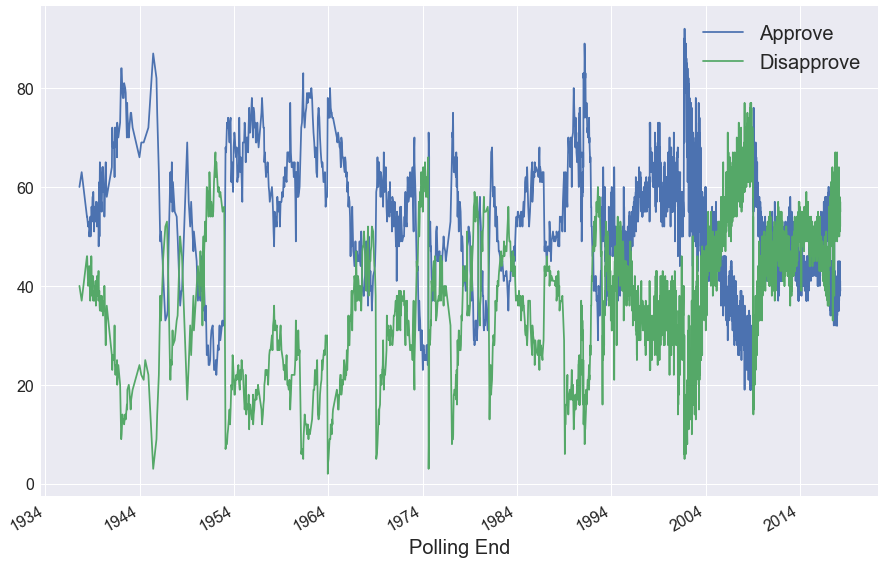

In [17]:
combined_df.plot('Polling End', ['Approve', 'Disapprove'])
plt.savefig('data/approval.png')

To make predictions of approval based on speech sentiment, I get approval ratings subset based on polls within a week of a state of the union address. 

In [11]:
def get_rating_subset(speech, rating):
    temp_df = pd.DataFrame()
    for i, speech_row in speech.iterrows():
        for j, rating_row in rating.iterrows():
            if speech_row['date'] >= (rating_row['Polling Start'] - pd.Timedelta(days=7)) and speech_row['date'] <= (rating_row['Polling End'] + pd.Timedelta(days=7)):
                data = rating_row[['Name', 'Polling Start', 'Polling End', 'Approve', 'Disapprove']]
                temp_df = temp_df.append(data)
    temp_df.to_csv('data/apporvals_subset.csv', index=False)
    return temp_df

In [12]:
def speech_num_words(speech):
    return len(word_tokenize(speech))

def speech_num_sentences(speech):
    return len(sent_tokenize(speech))

def approval_features(all_df, speeches):
    for col in ['Approve', 'Disapprove']:
        for agg_type in ['mean', 'median', 'min', 'max', 'std']:
            new_col = '{}_{}'.format(col.lower(), agg_type)
            speeches[new_col] = pd.Series(list(round(all_df.groupby(['date'])[col].agg(agg_type), 3)), index=speeches.index)

In [13]:
# all_df['num_words'] = all_df['speech'].apply(speech_num_words)
# all_df['num_sentences'] = all_df['speech'].apply(speech_num_sentences)
# approval_features(all_df, speeches)

In [14]:
# all_df.to_pickle('data/approval_features_temp.pkl')

In [15]:
# clean_df = speeches.merge(all_df[['date', 'num_words', 'num_sentences']], on='date', how='left').drop_duplicates(subset='date', keep='last')
# clean_df.to_pickle('data/clean_speech_approvals.pkl')
# clean_df.to_csv('data/clean_speech_approvals.csv', index=False)

In [16]:
clead_df = pd.read_pickle('data/clean_speech_approvals.pkl')